In [20]:
import pandas as pd
from pytorch_forecasting.data.encoders import TorchNormalizer

import numpy as np 
import os 
import glob
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import EncoderNormalizer, GroupNormalizer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import CrossEntropy
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.utils import profile
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
import talib
from talib import ADX,ADXR,APO,AD,ADOSC,OBV

In [150]:
path = ".\\price\\raw"
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [151]:
data = []
for f in csv_files:     
    # read the csv file
    df = pd.read_csv(f)
    data.append(df)

In [152]:
# preprocessing

In [153]:
clean_df= pd.DataFrame()
count = 0
for i in data:
    i.Date = pd.to_datetime(i.Date)
    # Feature engineering
    i['Return'] = i.Close.pct_change(1)
    i['Day'] = i.Date.dt.day
    i['Month'] = i.Date.dt.month
    i['Year'] = i.Date.dt.year
    i['ADX']  = ADX(i['High'], i['Low'], i['Close'], timeperiod=14)
    i['ADXR'] = ADXR(i['High'], i['Low'], i['Close'], timeperiod=14)
    i['APO']  = APO(i['Close'], fastperiod=12, slowperiod=26, matype=0)
    i['AD']   = AD(i['High'],  i['Low'], i['Low'], i['Volume'])
    i['ADOSC']     = ADOSC(i['High'], i['Low'], i['Close'], i['Volume'], fastperiod=3, slowperiod=10)
    i['OBV'] = OBV(i['Close'], i['Volume'])
    i['y'] = np.where(i['Return']>0,1,0)
    i['y'] = i['y'].shift(-1)
    i.drop(i.tail(1).index,inplace=True)
    i['ID'] = count
    min_date = i['Date'].min()
    i["time_idx"] = i["Date"].map(lambda current_date: (current_date - min_date).days)
    count+=1
    clean_df = pd.concat([clean_df,i])

<AxesSubplot:>

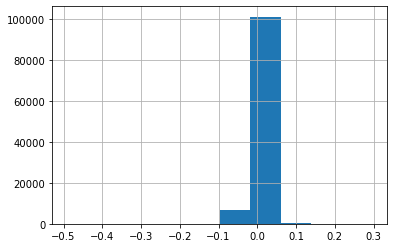

In [154]:
clean_df.Return.hist()

In [155]:
clean_df.fillna(-1,inplace=True) # pad features

In [156]:
clean_df[clean_df.ID==1]

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx
0,2012-09-04,17.340000,17.370001,17.139999,17.240000,14.469431,1474300.0,-1.000000,4,9,2012,-1.000000,-1.000000,-1.000000,-1.474300e+06,-1.000000,1474300.0,1.0,1,0
1,2012-09-05,17.219999,17.389999,17.160000,17.320000,14.536574,3186600.0,0.004640,5,9,2012,-1.000000,-1.000000,-1.000000,-4.660900e+06,-1.000000,4660900.0,1.0,1,1
2,2012-09-06,17.690001,17.959999,17.680000,17.910000,15.031758,3082300.0,0.034065,6,9,2012,-1.000000,-1.000000,-1.000000,-7.743200e+06,-1.000000,7743200.0,1.0,1,2
3,2012-09-07,18.580000,18.700001,18.510000,18.650000,15.652837,3005200.0,0.041318,7,9,2012,-1.000000,-1.000000,-1.000000,-1.074840e+07,-1.000000,10748400.0,0.0,1,3
4,2012-09-10,18.760000,18.770000,18.510000,18.540001,15.560513,1920300.0,-0.005898,10,9,2012,-1.000000,-1.000000,-1.000000,-1.266870e+07,-1.000000,8828100.0,1.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2017-08-25,23.200001,23.360001,23.180000,23.309999,23.309999,1918600.0,0.009091,25,8,2017,27.066143,28.939085,-0.266795,-2.385878e+09,-463449.904357,109812800.0,0.0,1,1816
1253,2017-08-28,23.240000,23.250000,23.059999,23.070000,23.070000,1152600.0,-0.010296,28,8,2017,25.830097,28.526675,-0.217885,-2.387030e+09,-640643.202281,108660200.0,0.0,1,1819
1254,2017-08-29,22.940001,22.969999,22.879999,22.920000,22.920000,1504200.0,-0.006502,29,8,2017,25.245319,28.738182,-0.186154,-2.388535e+09,-708059.230618,107156000.0,0.0,1,1820
1255,2017-08-30,22.860001,22.910000,22.809999,22.840000,22.840000,1269600.0,-0.003490,30,8,2017,24.909901,29.038376,-0.171090,-2.389804e+09,-832849.293084,105886400.0,1.0,1,1821


In [157]:
clean_df.groupby('ID')['time_idx'].count()

ID
0     1257
1     1257
2     1176
3     1257
4      700
      ... 
83    1257
84    1257
85    1257
86    1257
87    1257
Name: time_idx, Length: 88, dtype: int64

In [158]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108504 entries, 0 to 1256
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       108504 non-null  datetime64[ns]
 1   Open       108504 non-null  float64       
 2   High       108504 non-null  float64       
 3   Low        108504 non-null  float64       
 4   Close      108504 non-null  float64       
 5   Adj Close  108504 non-null  float64       
 6   Volume     108504 non-null  float64       
 7   Return     108504 non-null  float64       
 8   Day        108504 non-null  int64         
 9   Month      108504 non-null  int64         
 10  Year       108504 non-null  int64         
 11  ADX        108504 non-null  float64       
 12  ADXR       108504 non-null  float64       
 13  APO        108504 non-null  float64       
 14  AD         108504 non-null  float64       
 15  ADOSC      108504 non-null  float64       
 16  OBV        108504 non-

In [159]:
clean_df.describe() # validate on features range

,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx
count,108504.000000,108504.000000,108504.000000,108504.000000,108504.000000,1.085040e+05,108504.000000,108504.000000,108504.000000,108504.000000,108504.000000,108504.000000,108504.000000,1.085040e+05,1.085040e+05,1.085040e+05,108504.000000,108504.000000,108504.000000
mean,2413.754485,2425.610398,2400.134830,2413.508402,2409.201168,9.063146e+06,-0.000310,15.715587,6.541381,2014.694463,22.591884,22.311677,9.008813,-6.150593e+09,8.569023e+05,1.842190e+08,0.514681,43.985733,904.820486
std,21734.798820,21837.367050,21615.455278,21732.189978,21732.652876,1.797932e+07,0.031744,8.731011,3.423910,1.485687,9.951825,9.309798,277.232906,1.223480e+10,1.259484e+07,5.759422e+08,0.499787,25.328378,526.156130
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,1.000000,1.000000,2012.000000,-1.000000,-1.000000,-7212.064103,-1.271412e+11,-2.889514e+08,-3.351179e+09,0.000000,0.000000,0.000000
25%,40.349998,40.635626,40.080002,40.360001,36.479530,1.197200e+06,-0.006261,8.000000,4.000000,2013.000000,16.032379,16.718694,-0.565641,-5.803659e+09,-7.708275e+05,6.968750e+05,0.000000,22.000000,447.000000
50%,65.942501,66.470001,65.440002,65.980003,60.495302,3.550750e+06,0.000424,16.000000,7.000000,2015.000000,21.179166,21.400940,0.127981,-1.970361e+09,1.047829e+05,5.232825e+07,1.000000,44.000000,903.000000
75%,97.660004,98.440002,96.919998,97.662503,91.064357,9.007300e+06,0.007245,23.000000,10.000000,2016.000000,28.275290,27.557247,0.858670,-4.780734e+08,2.053643e+06,2.163953e+08,1.000000,66.000000,1359.000000
max,271000.000000,272857.000000,270985.000000,271450.000000,271450.000000,6.166205e+08,0.296115,31.000000,12.000000,2017.000000,77.260191,72.423404,10345.512821,0.000000e+00,3.873528e+08,6.096794e+09,1.000000,87.000000,1822.000000


In [160]:
clean_df[clean_df['Open']==clean_df['Open'].max()] # check outler value

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx
1256,2017-08-31,271000.0,272857.0,270985.0,271450.0,271450.0,200.0,0.003809,31,8,2017,20.535821,22.024905,2090.891026,-13144100.0,138.236124,1953300.0,0.0,14,1822


In [161]:
clean_df[clean_df.ID==14] # validate on price range of the stock 14

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx
0,2012-09-04,126340.0,126654.0,126077.0,126279.0,126279.0,24300.0,-1.000000,4,9,2012,-1.000000,-1.000000,-1.000000,-24300.0,-1.000000,24300.0,1.0,14,0
1,2012-09-05,126315.0,128000.0,126315.0,127770.0,127770.0,68700.0,0.011807,5,9,2012,-1.000000,-1.000000,-1.000000,-93000.0,-1.000000,93000.0,1.0,14,1
2,2012-09-06,128050.0,129597.0,128050.0,129597.0,129597.0,80900.0,0.014299,6,9,2012,-1.000000,-1.000000,-1.000000,-173900.0,-1.000000,173900.0,1.0,14,2
3,2012-09-07,129887.0,130039.0,129610.0,129942.0,129942.0,90900.0,0.002662,7,9,2012,-1.000000,-1.000000,-1.000000,-264800.0,-1.000000,264800.0,0.0,14,3
4,2012-09-10,129961.0,130717.0,129700.0,129700.0,129700.0,39800.0,-0.001862,10,9,2012,-1.000000,-1.000000,-1.000000,-304600.0,-1.000000,225000.0,1.0,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2017-08-25,268820.0,270550.0,268820.0,269761.0,269761.0,200.0,0.004453,25,8,2017,22.985704,24.663803,2334.025641,-13143000.0,156.327567,1952800.0,0.0,14,1816
1253,2017-08-28,270400.0,270400.0,267450.0,268035.0,268035.0,300.0,-0.006398,28,8,2017,21.890983,23.881242,2220.576923,-13143300.0,73.750441,1952500.0,1.0,14,1819
1254,2017-08-29,267250.0,268160.0,266045.0,268090.0,268090.0,300.0,0.000205,29,8,2017,20.505148,22.969925,2244.705128,-13143600.0,122.400345,1952800.0,1.0,14,1820
1255,2017-08-30,268450.0,271470.0,268100.0,270420.0,270420.0,300.0,0.008691,30,8,2017,20.275626,22.253148,2158.743590,-13143900.0,167.147759,1953100.0,1.0,14,1821


In [162]:
clean_df[clean_df.duplicated()] # check duplicates

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx


In [163]:
clean_df.corr()

,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV,y,ID,time_idx
Open,1.000000,0.999988,0.999988,0.999974,0.999974,-0.054602,0.001423,0.000474,-0.001468,0.015459,0.006317,0.007745,0.302976,0.054188,-0.007312,-0.034137,-0.001129,-0.126527,0.018856
High,0.999988,1.000000,0.999987,0.999989,0.999989,-0.054606,0.001526,0.000444,-0.001452,0.015435,0.006323,0.007760,0.302736,0.054194,-0.007312,-0.034140,-0.001155,-0.126539,0.018834
Low,0.999988,0.999987,1.000000,0.999988,0.999988,-0.054599,0.001512,0.000481,-0.001445,0.015485,0.006292,0.007721,0.303384,0.054183,-0.007309,-0.034134,-0.001176,-0.126517,0.018887
Close,0.999974,0.999989,0.999988,1.000000,1.000000,-0.054603,0.001620,0.000436,-0.001457,0.015471,0.006294,0.007731,0.303189,0.054188,-0.007308,-0.034137,-0.001194,-0.126528,0.018869
Adj Close,0.999974,0.999989,0.999988,1.000000,1.000000,-0.054572,0.001622,0.000438,-0.001461,0.015569,0.006302,0.007743,0.303189,0.054137,-0.007304,-0.034097,-0.001194,-0.126540,0.018965
Volume,-0.054602,-0.054606,-0.054599,-0.054603,-0.054572,1.000000,-0.002609,0.004373,-0.011718,-0.071926,0.051498,0.037154,-0.016119,-0.611069,0.029185,0.315207,0.000864,-0.137323,-0.071947
Return,0.001423,0.001526,0.001512,0.001620,0.001622,-0.002609,1.000000,0.031798,-0.019761,0.042138,0.060994,0.064320,0.002137,-0.014243,0.040642,0.013827,-0.002822,-0.001828,0.041027
Day,0.000474,0.000444,0.000481,0.000436,0.000438,0.004373,0.031798,1.000000,-0.004358,0.006396,0.012647,0.000896,0.001592,-0.005907,-0.002277,0.004051,-0.000207,-0.000278,0.021931
Month,-0.001468,-0.001452,-0.001445,-0.001457,-0.001461,-0.011718,-0.019761,-0.004358,1.000000,-0.252445,-0.032060,-0.056642,0.003818,0.017513,-0.012113,-0.005386,-0.012470,0.002211,-0.061676
Year,0.015459,0.015435,0.015485,0.015471,0.015569,-0.071926,0.042138,0.006396,-0.252445,1.000000,0.061623,0.115900,-0.000117,-0.254387,0.023880,0.123721,0.000232,-0.018016,0.958035


In [164]:
y = clean_df['y']
clean_df.drop(['y','Date','ID','time_idx'],axis=1,inplace=True)

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     clean_df, y, test_size=0.3, random_state=42,shuffle=False)

In [166]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Return,Day,Month,Year,ADX,ADXR,APO,AD,ADOSC,OBV
0,95.108574,96.448570,94.928574,96.424286,87.121140,91973000.0,-1.000000,4,9,2012,-1.000000,-1.000000,-1.000000,-91973000.0,-1.000000,91973000.0
1,96.510002,96.621429,95.657143,95.747147,86.509338,84093800.0,-0.007022,5,9,2012,-1.000000,-1.000000,-1.000000,-176066800.0,-1.000000,7879200.0
2,96.167145,96.898575,95.828575,96.610001,87.288956,97799100.0,0.009012,6,9,2012,-1.000000,-1.000000,-1.000000,-273865900.0,-1.000000,105678300.0
3,96.864288,97.497147,96.538574,97.205711,87.827171,82416600.0,0.006166,7,9,2012,-1.000000,-1.000000,-1.000000,-356282500.0,-1.000000,188094900.0
4,97.207146,97.612854,94.585716,94.677139,85.542564,121999500.0,-0.026013,10,9,2012,-1.000000,-1.000000,-1.000000,-478282000.0,-1.000000,66095400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,21.450001,21.709999,21.299999,21.670000,21.670000,41500.0,0.008376,7,3,2013,10.409551,13.300017,0.166987,-9874100.0,-13597.690550,-53300.0
126,21.860001,21.860001,21.469999,21.690001,21.690001,32600.0,0.000923,8,3,2013,9.677443,12.926297,0.238846,-9906700.0,1920.621942,-20700.0
127,21.740000,21.860001,21.590000,21.719999,21.719999,61900.0,0.001383,11,3,2013,8.997628,12.197945,0.235641,-9968600.0,7364.743096,41200.0
128,21.620001,21.990000,21.520000,21.709999,21.709999,99400.0,-0.000460,12,3,2013,8.698873,11.572145,0.196218,-10068000.0,2865.940618,-58200.0


In [167]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [168]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 500 , max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=500, random_state=0)

In [169]:
y_pred = clf.predict(X_test)

In [170]:
confusion_matrix(y_test, y_pred)

array([[  673, 15313],
       [  512, 16054]], dtype=int64)

In [171]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6698516679531847

In [172]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.513854755468174

In [173]:
import xgboost as xgb
xgb_model  = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model .fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [174]:
y_pred = xgb_model.predict(X_test)

In [175]:
confusion_matrix(y_test, y_pred)

array([[ 8555,  7431],
       [ 5990, 10576]], dtype=int64)

In [176]:
f1_score(y_test, y_pred)

0.6118069013391952

In [177]:
accuracy_score(y_test, y_pred)

0.5877058245269108

In [178]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [179]:
y_pred = clf.predict(X_test)

In [180]:
confusion_matrix(y_test, y_pred)

array([[  142, 15844],
       [  118, 16448]], dtype=int64)

In [181]:
f1_score(y_test, y_pred)

0.6732981292725858

In [182]:
accuracy_score(y_test, y_pred)

0.509646104694028